In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext blackcellmagic

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import normalize, StandardScaler

import statsmodels.api as sm

/home/phong/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Importation

In [3]:
eleves = pd.read_csv("Données-élèves/Défi1-Données-élèves.csv")
cours = pd.read_csv("Données-personnels/cours.csv")
structures = pd.read_csv("Données-personnels/structures.csv", sep=";")
pcs = pd.read_csv("Données-élèves/n_pcs_.csv")

/home/phong/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
etablissements = pd.read_csv(
    "fr-en-adresse-et-geolocalisation-etablissements-premier-et-second-degre.csv",
    sep=";",
)
etablissements = etablissements[
    ["Code établissement", "Secteur Public/Privé", "Coordonnee X", "Coordonnee Y"]
]
etablissements["Prive"] = np.where(
    etablissements["Secteur Public/Privé"] == "Privé", 1, 0
)


/home/phong/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7,22,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
eleves = eleves.merge(pcs, how="left", left_on="PCS_resp1", right_on="PCS")
eleves = eleves[
    eleves["MEFSTAT11"].str[0:3].replace(" ", "").isin(["211", "213", "243"])
]
eleves["Identifiant_division"] = eleves["Identifiant_division"].str.replace(" ", "")
# eleves.to_csv("eleves_pcs.csv", index=False)


In [6]:
personnels = cours.merge(structures, how="left", on=["uaarne", "elstco", "elstty"])
personnels = personnels[
    personnels["mefsta11"].str[0:3].replace(" ", "").isin(["211", "213", "243"])
]
# personnels.to_csv("personnels.csv", index=False)


In [7]:
eleves.columns

Index(['ID', 'commune_residence', 'X', 'Y', 'SEXE', 'Annee_naissance',
       'PCS_resp1', 'Regime_scolaire', 'Etablissement_en_cours',
       'Code_nature_etablissement', 'Secteur_annee_en_cours',
       'Identifiant_division', 'Contrat_division', 'MEF_annee_en_cours',
       'Type_MEF_annee_en_cours', 'MEFSTAT11', 'Option1_annee_en_cours',
       'Option2_annee_en_cours', 'Option3_annee_en_cours',
       'Option4_annee_en_cours', 'Option5_annee_en_cours',
       'Option6_annee_en_cours', 'Option7_annee_en_cours',
       'Option8_annee_en_cours', 'Option9_annee_en_cours',
       'Option10_annee_en_cours', 'Option11_annee_en_cours',
       'Option12_annee_en_cours', 'Modalite_election_option1',
       'Modalite_election_option2', 'Modalite_election_option3',
       'Modalite_election_option4', 'Modalite_election_option5',
       'Modalite_election_option6', 'Modalite_election_option7',
       'Modalite_election_option8', 'Modalite_election_option9',
       'Modalite_election_option10',

In [8]:
personnels.columns

Index(['uaarne', 'elstco', 'elstty', 'dispco', 'menhag', 'matdpd', 'GRADCO',
       'DISCCO', 'PLG_CODE_COMMUNE', 'X', 'Y', 'identifiant', 'secteur',
       'mefsta11'],
      dtype='object')

In [9]:
df = eleves.merge(personnels, how="left", left_on=["Etablissement_en_cours", "Identifiant_division"], right_on=["uaarne", "elstco"])

## Exploration

## Pre-features

In [10]:
df["hommes"] = (df["SEXE"] == 1)
df["femmes"] = (df["SEXE"] == 2)

In [11]:
options_temp = df[
    [
        "Option1_annee_en_cours",
        "Option2_annee_en_cours",
        "Option3_annee_en_cours",
        "Option4_annee_en_cours",
        "Option5_annee_en_cours",
        "Option6_annee_en_cours",
        "Option7_annee_en_cours",
        "Option8_annee_en_cours",
        "Option9_annee_en_cours",
        "Option10_annee_en_cours",
        "Option11_annee_en_cours",
        "Option12_annee_en_cours",
    ]
].values

df["options_list"] = pd.Series([x[~np.isnan(x)] for x in options_temp])


In [12]:
df["score"] = np.where(
    df["PCS_INDICATEUR"] == "A",
    4,
    np.where(
        df["PCS_INDICATEUR"] == "B",
        3,
        np.where(
            df["PCS_INDICATEUR"] == "C", 2, np.where(df["PCS_INDICATEUR"] == "D", 1, 0)
        ),
    ),
)


In [13]:
df["internes"] = df["Regime_scolaire"].isin([3, 4, 5])


In [14]:
df = (
    df.merge(
        etablissements, how="left", left_on="Etablissement_en_cours", right_on="Code établissement"
    )
    .set_index("Code établissement")
    .drop("Secteur Public/Privé", axis=1)
)


In [15]:
df["distance"] = np.sqrt(
    (df["X_x"] - df["Coordonnee X"]) ** 2 + (df["Y_x"] - df["Coordonnee Y"]) ** 2
)


In [16]:
df.columns

Index(['ID', 'commune_residence', 'X_x', 'Y_x', 'SEXE', 'Annee_naissance',
       'PCS_resp1', 'Regime_scolaire', 'Etablissement_en_cours',
       'Code_nature_etablissement', 'Secteur_annee_en_cours',
       'Identifiant_division', 'Contrat_division', 'MEF_annee_en_cours',
       'Type_MEF_annee_en_cours', 'MEFSTAT11', 'Option1_annee_en_cours',
       'Option2_annee_en_cours', 'Option3_annee_en_cours',
       'Option4_annee_en_cours', 'Option5_annee_en_cours',
       'Option6_annee_en_cours', 'Option7_annee_en_cours',
       'Option8_annee_en_cours', 'Option9_annee_en_cours',
       'Option10_annee_en_cours', 'Option11_annee_en_cours',
       'Option12_annee_en_cours', 'Modalite_election_option1',
       'Modalite_election_option2', 'Modalite_election_option3',
       'Modalite_election_option4', 'Modalite_election_option5',
       'Modalite_election_option6', 'Modalite_election_option7',
       'Modalite_election_option8', 'Modalite_election_option9',
       'Modalite_election_option

## Features

In [17]:
nb_eleves = df.groupby("Etablissement_en_cours")["ID"].nunique()


In [18]:
nb_internes = (
    df.groupby(["Etablissement_en_cours", "ID"])["internes"]
    .nth(0)
    .groupby("Etablissement_en_cours")
    .sum()
)
pourcent_internes = (nb_internes / nb_eleves).rename("pourcent_internes")


In [19]:
nb_option_1 = df.groupby("Etablissement_en_cours")["Option1_annee_en_cours"].nunique()
nb_option_2 = df.groupby("Etablissement_en_cours")["Option2_annee_en_cours"].nunique()
nb_option_3 = df.groupby("Etablissement_en_cours")["Option3_annee_en_cours"].nunique()
nb_option_4 = df.groupby("Etablissement_en_cours")["Option4_annee_en_cours"].nunique()
nb_option_5 = df.groupby("Etablissement_en_cours")["Option5_annee_en_cours"].nunique()
nb_option_6 = df.groupby("Etablissement_en_cours")["Option6_annee_en_cours"].nunique()


In [20]:
nb_hommes = (
    df.groupby(["Etablissement_en_cours", "ID"])["hommes"]
    .nth(0)
    .groupby("Etablissement_en_cours")
    .sum()
)
nb_femmes = (
    df.groupby(["Etablissement_en_cours", "ID"])["femmes"]
    .nth(0)
    .groupby("Etablissement_en_cours")
    .sum()
)


In [21]:
total_options = (
    df.groupby("Etablissement_en_cours")["options_list"]
    .apply(np.hstack)
    .apply(np.unique)
)


In [22]:
option_oc = (
    total_options.apply(lambda x: 35807 in x)
).rename("option_oc")

option_aide = (
    total_options.apply(lambda x: 9800 in x)
).rename("option_aide")

option_art = (
    total_options.apply(lambda x: 99800 in x)
).rename("option_art")

option_sport = (
    total_options.apply(lambda x: 109800 in x)
).rename("option_sport")

option_portugais = (
    total_options.apply(lambda x: 31102 in x)
).rename("option_portugais")

In [23]:
a = pd.Series(np.concatenate(total_options))
test = a.value_counts().sort_index().rename_axis('code').reset_index(name='total')

In [24]:
from collections import Counter
from  itertools import chain

test_2 = pd.Series(Counter(chain(*total_options))).sort_index().rename_axis('code').reset_index(name='total')


In [25]:
test_2.sort_values("total", ascending=False)

,code,total
11,30201.0,418
21,30602.0,415
2,20300.0,308
7,30102.0,151
12,30202.0,137
20,30601.0,114
35,38002.0,72
33,35807.0,47
1,9800.0,46
42,99800.0,43


In [26]:
nb_options = total_options.apply(len)

In [27]:
score_mean = df.groupby("Etablissement_en_cours")["score"].mean()

In [28]:
D_temp = (
    df.groupby(["Etablissement_en_cours", "ID"])["score"]
    .nth(0)
    .groupby("Etablissement_en_cours")
    .value_counts()
)
nb_D = D_temp[D_temp.index.get_level_values(1) == 1].rename("D")
nb_D.index = nb_D.index.droplevel(1)

C_temp = (
    df.groupby(["Etablissement_en_cours", "ID"])["score"]
    .nth(0)
    .groupby("Etablissement_en_cours")
    .value_counts()
)
nb_C = C_temp[C_temp.index.get_level_values(1) == 2].rename("C")
nb_C.index = nb_C.index.droplevel(1)

B_temp = (
    df.groupby(["Etablissement_en_cours", "ID"])["score"]
    .nth(0)
    .groupby("Etablissement_en_cours")
    .value_counts()
)
nb_B = B_temp[B_temp.index.get_level_values(1) == 3].rename("B")
nb_B.index = nb_B.index.droplevel(1)

A_temp = (
    df.groupby(["Etablissement_en_cours", "ID"])["score"]
    .nth(0)
    .groupby("Etablissement_en_cours")
    .value_counts()
)
nb_A = A_temp[A_temp.index.get_level_values(1) == 4].rename("A")
nb_A.index = nb_A.index.droplevel(1)


In [29]:
mean_distance = (
    df.groupby(["Etablissement_en_cours", "ID"])["distance"]
    .nth(0)
    .groupby("Etablissement_en_cours")
    .mean()
).rename("mean_distance")

In [30]:
prive = (
    df.groupby(["Etablissement_en_cours"])["Prive"]
    .nth(0)
).rename("prive")

## Final merge

In [31]:
final_df = pd.concat(
    [
        nb_eleves,
        pourcent_internes,
        nb_hommes,
        nb_femmes,
        nb_options,
        nb_A,
        nb_B,
        nb_C,
        nb_D,
        mean_distance,
        prive,
        option_oc,
        option_aide,
        option_art,
        option_sport,
        option_portugais,
    ],
    axis=1,
).fillna(0)
final_df = final_df.rename(
    index=str, columns={"ID": "nb_eleves", "options_list": "nb_options"}
)


/home/phong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [32]:
# final_df = (
#     final_df.merge(
#         etablissements, how="left", left_index=True, right_on="Code établissement"
#     )
#     .set_index("Code établissement")
#     .drop("Secteur Public/Privé", axis=1)
# )


In [33]:
# final_df = final_df.drop("Coordonnee X", axis=1)
# final_df = final_df.drop("Coordonnee Y", axis=1)

In [34]:
final_df["pourcent_femmes"] = final_df["femmes"] / final_df["nb_eleves"]
final_df = final_df.drop("hommes", axis=1)
final_df = final_df.drop("femmes", axis=1)

In [35]:
final_df["pourcent_D"] = final_df["D"] / final_df["nb_eleves"]
final_df["pourcent_C"] = final_df["C"] / final_df["nb_eleves"]
final_df["pourcent_B"] = final_df["B"] / final_df["nb_eleves"]
final_df["pourcent_A"] = final_df["A"] / final_df["nb_eleves"]

In [36]:
# def entropy(x):
#     Nj, pA, pB, pC, pD = x["nb_eleves"], x["pourcent_A"], x["pourcent_B"], x["pourcent_C"], x["pourcent_D"]
#     hpj = pA * np.log(pA) + pB * np.log(pB) + pC * np.log(pC) + pD * np.log(pD)
#     return (Nj / N) * ((hp - hpj) / hp)


In [37]:
# N = final_df["nb_eleves"].sum()
# hp = (final_df["A"].sum() / N) * np.log((final_df["A"].sum() / N)) + (final_df["B"].sum() / N) * np.log((final_df["B"].sum() / N)) + (final_df["C"].sum() / N) * np.log((final_df["C"].sum() / N)) + (final_df["D"].sum() / N) * np.log((final_df["D"].sum() / N))

In [38]:
# final_df["entropy"] = final_df.apply(entropy, axis=1)

In [39]:
final_df.to_csv("etablissements_basique.csv")

In [40]:
final_df.columns

Index(['nb_eleves', 'pourcent_internes', 'nb_options', 'A', 'B', 'C', 'D',
       'mean_distance', 'prive', 'option_oc', 'option_aide', 'option_art',
       'option_sport', 'option_portugais', 'pourcent_femmes', 'pourcent_D',
       'pourcent_C', 'pourcent_B', 'pourcent_A'],
      dtype='object')

## Modeling

In [41]:
final_df = final_df[
    [
        "nb_eleves",
        "pourcent_internes",
        "nb_options",
        "prive",
        "pourcent_femmes",
        "mean_distance",
        "pourcent_D",
        "option_oc",
        "option_aide",
        "option_art",
        "option_sport",
        "option_portugais",
    ]
]


In [42]:
# continuous = ["nb_eleves", "pourcent_femmes", "nb_options"]

In [43]:
# means = dict()
# stds = dict()
# for x in continuous:
#     means[x] = final_df[x].mean()
#     stds[x] = final_df[x].std()
#     final_df[x] = (final_df[x] - final_df[x].mean()) / final_df[x].std()


In [44]:
X = final_df.drop("pourcent_D", axis=1)
y = final_df["pourcent_D"]


In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)


In [46]:
regr = RandomForestRegressor(n_estimators=300, max_depth=5)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

# print('Coefficients: \n', regr.coef_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % r2_score(y_test, y_pred))


Mean squared error: 0.02


In [47]:
# mod = sm.OLS(y, X)

In [48]:
# res = mod.fit()
# print(res.summary())

In [49]:
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]


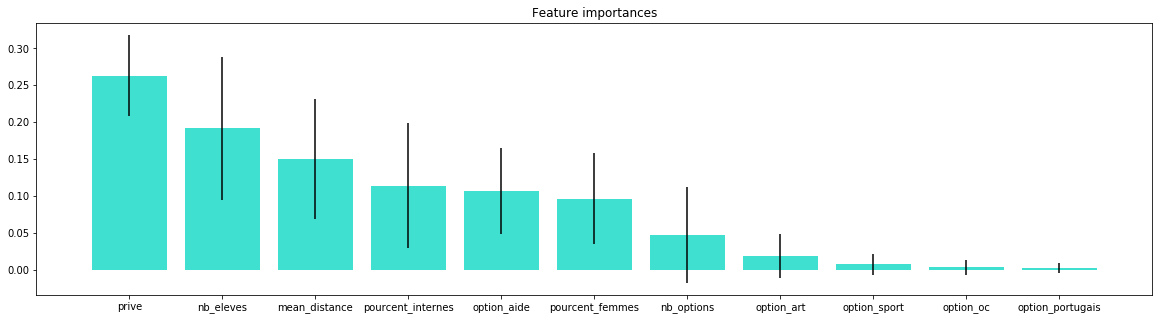

In [50]:
plt.figure(figsize=(20, 5))
plt.title("Feature importances")
plt.bar(
    range(X.shape[1]),
    importances[indices],
    color="turquoise",
    yerr=std[indices],
    align="center",
)
plt.xticks(range(X.shape[1]), X.columns[indices])
plt.xlim([-1, X.shape[1]])
plt.show()


## Example

In [53]:
etabA = "0331461J"
etabB = "0330140Y"
etabC = "0332082J"

In [57]:
dataA = final_df[final_df.index == etabA]#.drop("pourcent_D", axis=1)
dataA

,nb_eleves,pourcent_internes,nb_options,prive,pourcent_femmes,mean_distance,pourcent_D,option_oc,option_aide,option_art,option_sport,option_portugais
0331461J,858,0.0,7,0,0.504662,1108.263381,0.096737,False,False,False,False,False


In [58]:
dataB = final_df[final_df.index == etabB]#.drop("pourcent_D", axis=1)
dataB

,nb_eleves,pourcent_internes,nb_options,prive,pourcent_femmes,mean_distance,pourcent_D,option_oc,option_aide,option_art,option_sport,option_portugais
0330140Y,550,0.0,7,0,0.496364,1406.120209,0.461818,False,True,False,False,False


In [59]:
dataC = final_df[final_df.index == etabC]#.drop("pourcent_D", axis=1)
dataC

,nb_eleves,pourcent_internes,nb_options,prive,pourcent_femmes,mean_distance,pourcent_D,option_oc,option_aide,option_art,option_sport,option_portugais
0332082J,440,0.0,7,0,0.459091,1169.994917,0.304545,False,False,False,True,True


In [500]:
dataA["option_oc"] = 0
#dataA["option_aide"] = 0
dataA["option_art"] = 0
dataA["option_sport"] = 0
dataA["option_portugais"] = 0

In [609]:
dataB["option_oc"] = 0
#dataB["option_aide"] = 1
dataB["option_art"] = 0
dataB["option_sport"] = 0
dataB["option_portugais"] = 0

In [614]:
dataC["option_oc"] = 0
#dataC["option_aide"] = 0
dataC["option_art"] = 0
dataC["option_sport"] = 0
dataC["option_portugais"] = 0

In [611]:
regr.predict(dataA)

array([0.16918472])

In [612]:
regr.predict(dataB)

array([0.41930594])

In [615]:
regr.predict(dataC)

array([0.2511063])

In [ ]:
etabA = "0331461J"
etabB = "0330140Y"
etabC = "0332082J"